<a href="https://colab.research.google.com/github/Thomas51-GtHb/Pub1/blob/main/App_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output

# 日本語フォント設定
try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib
    import japanize_matplotlib

# ==========================================
# 1. データの再生成 (一貫性のため再定義)
# ==========================================
def generate_complex_macro_data(n_depts=30, months=36, seed=123):
    np.random.seed(seed)
    records = []
    base_sales = np.random.normal(500, 50, n_depts)

    for dept_id in range(n_depts):
        psy_safety = 3.0
        career_growth = 3.0

        for t in range(months):
            # Inputs
            training_cost = max(0, np.random.normal(30, 10))
            manager_1on1 = np.random.poisson(2)

            # Mediators
            psy_safety = 0.7*psy_safety + 0.1*manager_1on1 + np.random.normal(0, 0.2)
            career_growth = 0.7*career_growth + 0.01*training_cost + np.random.normal(0, 0.2)

            # 阻害要因: 残業 (売上にはプラスだが、心理的安全性にはマイナス)
            overtime = (base_sales[dept_id] / 20) + np.random.normal(0, 5)
            overtime = max(0, overtime)
            psy_safety -= (overtime / 100) # ネガティブインパクト

            # Clip
            psy_safety = np.clip(psy_safety, 1, 5)
            career_growth = np.clip(career_growth, 1, 5)

            # Outcomes
            sales = base_sales[dept_id] + (career_growth * 20) + (overtime * 2) + np.random.normal(0, 20)
            quality = 80 + (psy_safety * 4) - (overtime * 0.5) + np.random.normal(0, 2)
            quality = np.clip(quality, 0, 100)

            # Financial
            labor_cost = overtime * 0.5
            profit = (sales * 0.2) - training_cost - labor_cost + (quality * 0.5)

            records.append({
                'Dept_ID': f'Dept_{dept_id:02d}',
                'Month': t,
                'Training_Cost': training_cost,
                'Manager_1on1': manager_1on1,
                'Overtime_Hours': overtime,
                'Psy_Safety': psy_safety,
                'Career_Growth': career_growth,
                'Sales_Performance': sales,
                'Quality_Score': quality,
                'Operating_Profit': profit
            })

    return pd.DataFrame(records)

df_complex = generate_complex_macro_data()

# ==========================================
# 2. Advanced Data Scope (ダッシュボード)
# ==========================================

print("【Module 1: Advanced Data Scope】")
print("多変量データの「トレンド」と「変数間の関係性」を検査します。\n")

# 変数リストの定義
input_vars = ['Training_Cost', 'Manager_1on1']
mediator_vars = ['Psy_Safety', 'Career_Growth', 'Overtime_Hours']
outcome_vars = ['Sales_Performance', 'Quality_Score', 'Operating_Profit']
all_vars = input_vars + mediator_vars + outcome_vars

# --- UI 1: トレンド・チェッカー (時系列確認) ---
def plot_trend(variable):
    plt.figure(figsize=(12, 4))
    # 全部署のスパゲッティ
    sns.lineplot(data=df_complex, x='Month', y=variable, units='Dept_ID', estimator=None,
                 color='gray', alpha=0.2, linewidth=0.5)
    # 平均線
    sns.lineplot(data=df_complex, x='Month', y=variable,
                 color='blue', linewidth=2, label='全社平均')

    plt.title(f'時系列トレンド: {variable}')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    # 統計量の表示
    desc = df_complex[variable].describe()
    print(f"【{variable} の基本統計量】")
    print(f"  平均: {desc['mean']:.2f} | 最小: {desc['min']:.2f} | 最大: {desc['max']:.2f} | 標準偏差: {desc['std']:.2f}")

# --- UI 2: リレーション・チェッカー (散布図確認) ---
def plot_scatter(x_var, y_var):
    # Ensure variables are numeric before correlation
    if not pd.api.types.is_numeric_dtype(df_complex[x_var]) or not pd.api.types.is_numeric_dtype(df_complex[y_var]):
        print(f"エラー: '{x_var}' または '{y_var}' が数値型ではありません。相関関係は計算できません。")
        return

    plt.figure(figsize=(8, 6))

    # 散布図と回帰直線
    sns.regplot(data=df_complex, x=x_var, y=y_var,
                scatter_kws={'alpha':0.3, 's':10}, line_kws={'color':'red'})

    # 相関係数の計算
    corr = df_complex[[x_var, y_var]].corr().iloc[0, 1]

    plt.title(f'関係性の検証: {x_var} vs {y_var}\n相関係数 r = {corr:.3f}')
    plt.grid(True, alpha=0.3)
    plt.show()

    # PMからのコメント（自動判定）
    if corr > 0.3:
        print("✅ 明確な「正の相関（右肩上がり）」があります。施策として機能しています。")
    elif corr < -0.3:
        print("⚠️ 明確な「負の相関（右肩下がり）」があります。トレードオフや阻害要因の可能性があります。")
    else:
        print("ℹ️ 相関は弱いです。直接的な関係は薄いか、他の要因が絡んでいる可能性があります。")

# --- タブ表示のためのウィジェット構成 ---
tab = widgets.Tab()

# Tab 1: トレンド確認
out1 = widgets.Output()
with out1:
    print("変数の動き（範囲や異常値）を確認してください。")
    widgets.interact(plot_trend, variable=all_vars);

# Tab 2: 関係性確認 (Scatter)
out2 = widgets.Output()
with out2:
    print("「仮説通りの相関」が出ているか確認してください。")
    print("例: Manager_1on1(X) -> Psy_Safety(Y) は右肩上がりか？")
    print("例: Overtime_Hours(X) -> Psy_Safety(Y) は右肩下がりか？")
    widgets.interact(plot_scatter, x_var=all_vars, y_var=all_vars);

tab.children = [out1, out2]
tab.set_title(0, '1. トレンド検査 (Time Series)')
tab.set_title(1, '2. 関係性検査 (Scatter Plot)')

display(tab)

【Module 1: Advanced Data Scope】
多変量データの「トレンド」と「変数間の関係性」を検査します。



【Jカーブ検証】
研修コストと利益の関係を、時間軸をずらして確認します。


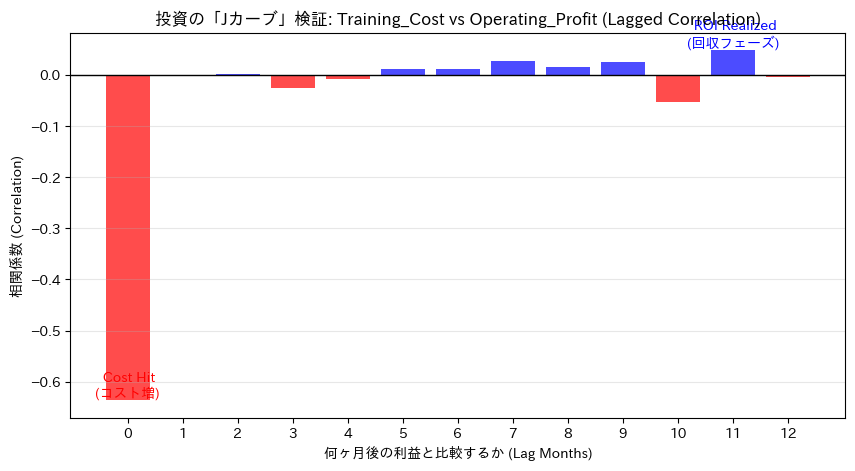

In [ ]:
def check_lagged_correlation(df, input_col='Training_Cost', target_col='Operating_Profit', max_lag=12):
    lags = range(max_lag + 1)
    correlations = []

    # 各ラグごとの相関を計算
    for lag in lags:
        # 利益を lag ヶ月分ずらす（未来の利益を持ってくる）
        shifted_target = df.groupby('Dept_ID')[target_col].shift(-lag)
        corr = df[input_col].corr(shifted_target)
        correlations.append(corr)

    # 可視化
    plt.figure(figsize=(10, 5))
    colors = ['red' if c < 0 else 'blue' for c in correlations]
    plt.bar(lags, correlations, color=colors, alpha=0.7)
    plt.axhline(0, color='black', linewidth=1)

    plt.title(f'投資の「Jカーブ」検証: {input_col} vs {target_col} (Lagged Correlation)')
    plt.xlabel('何ヶ月後の利益と比較するか (Lag Months)')
    plt.ylabel('相関係数 (Correlation)')
    plt.xticks(lags)
    plt.grid(axis='y', alpha=0.3)

    # 解説テキスト
    plt.text(0, correlations[0], ' Cost Hit\n(コスト増)', ha='center', va='bottom', color='red', fontweight='bold')
    if max(correlations) > 0:
        max_idx = correlations.index(max(correlations))
        plt.text(max_idx, correlations[max_idx], ' ROI Realized\n(回収フェーズ)', ha='center', va='bottom', color='blue', fontweight='bold')

    plt.show()

# 実行
print("【Jカーブ検証】")
print("研修コストと利益の関係を、時間軸をずらして確認します。")
check_lagged_correlation(df_complex)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import ipywidgets as widgets
from IPython.display import display

# 日本語フォント設定
try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib
    import japanize_matplotlib

# ==========================================
# Module 2: Path Finder (因果構造の可視化)
# ==========================================

print("【Module 2: Path Finder - 因果の構造化】")
print("組織データの「相関構造」をネットワーク図として可視化し、詳細な関係性を検査します。\n")

# --- 1. 変数のレイヤー定義 (SEMの構造) ---
# これにより、グラフを左から右へきれいに並べます
layers = {
    0: ['Training_Cost', 'Manager_1on1'],           # Input (施策)
    1: ['Psy_Safety', 'Career_Growth', 'Overtime_Hours'], # Mediator (状態)
    2: ['Sales_Performance', 'Quality_Score'],      # Outcome (業務成果)
    3: ['Operating_Profit']                         # Financial (財務)
}

# 変数名からレイヤー番号を引く辞書
node_layer_map = {}
for layer, nodes in layers.items():
    for node in nodes:
        node_layer_map[node] = layer

# SEMネットワークで使用する変数リストを定義
sem_vars = list(node_layer_map.keys())

# --- UI 1: SEMパス図の描画 ---
def plot_sem_network(threshold=0.3):
    plt.figure(figsize=(14, 8))

    # 相関行列の計算 (sem_varsに限定してDept_IDなどの非数値が混入しないようにする)
    corr_matrix = df_complex[sem_vars].corr()

    G = nx.DiGraph() # 有向グラフ

    # ノード追加
    for node, layer in node_layer_map.items():
        G.add_node(node, layer=layer)

    # エッジ追加 (左のレイヤーから右のレイヤーへの相関のみ描画 = 因果の仮定)
    edges = []
    colors = []
    widths = []

    # corr_matrixの列はsem_varsに含まれるもののみ
    for i in range(len(corr_matrix.columns)):
        for j in range(len(corr_matrix.columns)):
            source = corr_matrix.columns[i]
            target = corr_matrix.columns[j]

            # 同じレイヤーや逆流（右から左）は描かない（簡易SEMのため）
            if node_layer_map[source] < node_layer_map[target]:
                corr_val = corr_matrix.loc[source, target]

                # 閾値判定
                if abs(corr_val) >= threshold:
                    G.add_edge(source, target, weight=abs(corr_val))
                    edges.append((source, target))
                    widths.append(abs(corr_val) * 6) # 太さ
                    # 色分け
                    if corr_val > 0:
                        colors.append('#4169E1') # RoyalBlue (正)
                    else:
                        colors.append('#DC143C') # Crimson (負)

    # レイアウト (Multipartite Layout: レイヤーごとに整列)
    pos = nx.multipartite_layout(G, subset_key="layer")

    # 描画
    # ノード
    nx.draw_networkx_nodes(G, pos, node_size=4000, node_color='white', edgecolors='black', linewidths=1.5)
    # ラベル
    nx.draw_networkx_labels(G, pos, font_family='sans-serif', font_size=9, font_weight='bold')
    # エッジ
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=widths, edge_color=colors,
                           arrowstyle='-|>', arrowsize=20, connectionstyle="arc3,rad=0.1")

    # レイヤーラベルの表示
    layer_names = ["Input (施策)", "Mediator (心理/行動)", "Outcome (業務成果)", "Financial (財務)"]
    for i, name in enumerate(layer_names):
        # 各レイヤーの一番上のノード座標を取得して、その上にテキストを表示
        y_coords = [pos[n][1] for n in layers[i]]
        if y_coords:
            plt.text(pos[layers[i][0]][0], max(y_coords) + 0.15, name,
                     ha='center', fontsize=12, fontweight='bold', color='gray',
                     bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    plt.title(f"組織因果パス図 (閾値: |r| >= {threshold})", fontsize=16)
    plt.axis('off')

    # 凡例
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='#4169E1', lw=4, label='正の相関 (促進)'),
        Line2D([0], [0], color='#DC143C', lw=4, label='負の相関 (阻害)')
    ]
    plt.legend(handles=legend_elements, loc='lower right')
    plt.show()

# --- UI 2: パス詳細インスペクター (回帰直線の確認) ---
def inspect_path(source, target):
    # Ensure variables are numeric before correlation
    if not pd.api.types.is_numeric_dtype(df_complex[source]) or not pd.api.types.is_numeric_dtype(df_complex[target]):
        print(f"エラー: '{source}' または '{target}' が数値型ではありません。相関関係は計算できません。")
        return

    plt.figure(figsize=(10, 5))

    # 散布図と回帰直線
    sns.regplot(data=df_complex, x=source, y=target,
                scatter_kws={'alpha':0.5}, line_kws={'color':'green', 'linewidth':3})

    # 相関係数と回帰係数(簡易)
    corr = df_complex[[source, target]].corr().iloc[0, 1]

    plt.title(f'パス詳細分析: {source} -> {target}')
    plt.grid(True, alpha=0.3)

    # 解説
    if corr > 0:
        msg = f"📈 【正の連鎖】 {source} が増えると、{target} も増加する傾向があります (r={corr:.2f})"
    else:
        msg = f"📉 【負の連鎖/トレードオフ】 {source} が増えると、{target} は減少します (r={corr:.2f})"

    print(msg)
    plt.show()

# --- ダッシュボード構成 ---

# Tab 1: ネットワーク全体図
out_net = widgets.Output()
with out_net:
    print("スライダーを動かして、強いパス（太い線）だけを表示したり、弱い予兆（細い線）を探したりできます。")
    widgets.interact(plot_sem_network, threshold=widgets.FloatSlider(min=0.1, max=0.8, step=0.05, value=0.3));

# Tab 2: パス詳細
out_detail = widgets.Output()
with out_detail:
    print("気になる「矢印」の始点と終点を選んで、その中身（散布図）を確認してください。")
    # ドロップダウンの作成
    # 'Dept_ID'や'Month'などの非数値カラムを除外し、数値カラムのみをオプションとする
    all_numeric_vars = [col for col in df_complex.columns if pd.api.types.is_numeric_dtype(df_complex[col])]

    # デフォルト値
    dd_source = widgets.Dropdown(options=all_numeric_vars, value='Manager_1on1', description='始点(X):')
    dd_target = widgets.Dropdown(options=all_numeric_vars, value='Psy_Safety', description='終点(Y):')

    widgets.interact(inspect_path, source=dd_source, target=dd_target);

# タブの表示
tab_path = widgets.Tab()
tab_path.children = [out_net, out_detail]
tab_path.set_title(0, '1. SEMパス・ビジュアライザー')
tab_path.set_title(1, '2. パス詳細インスペクター')

display(tab_path)

【Module 2: Path Finder - 因果の構造化】
組織データの「相関構造」をネットワーク図として可視化し、詳細な関係性を検査します。



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import ipywidgets as widgets
from IPython.display import display

# 日本語フォント設定
try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib
    import japanize_matplotlib

# ==========================================
# 1. シミュレーション・エンジン (The Engine)
# ==========================================
print("【Module 3: Future Simulator - 未来の操縦席】")
print("過去データから算出した「パス係数」を用いて、未来のPLインパクトを予測します。\n")

# --- 係数の学習 (Machine Learning) ---
# 各パスの「傾き(Coef)」を回帰分析で特定し、辞書に保存する
coeffs = {}

def get_coef(X_col, y_col):
    X = sm.add_constant(df_complex[X_col])
    model = sm.OLS(df_complex[y_col], X).fit()
    return model.params[X_col]

# 1. Input -> Mediator
coeffs['Training_to_Growth'] = get_coef('Training_Cost', 'Career_Growth')
coeffs['1on1_to_Safety'] = get_coef('Manager_1on1', 'Psy_Safety')
coeffs['Overtime_to_Safety'] = get_coef('Overtime_Hours', 'Psy_Safety') # 負の係数になるはず

# 2. Mediator -> Outcome
coeffs['Growth_to_Sales'] = get_coef('Career_Growth', 'Sales_Performance')
coeffs['Safety_to_Quality'] = get_coef('Psy_Safety', 'Quality_Score')
coeffs['Overtime_to_Sales'] = get_coef('Overtime_Hours', 'Sales_Performance') # 正の係数(労働量)

# 3. Outcome -> Financial (簡易PLモデル)
# ※ここは回帰ではなく、PL構造上の定義値（または回帰）を使う
# 利益 = (売上 * 0.2) + (品質 * 0.5) - コスト
coeffs['Margin_Rate'] = 0.2
coeffs['Quality_Bonus'] = 0.5

# --- シミュレーション関数 ---
def run_simulation(delta_training, delta_1on1, delta_overtime):
    # 現状の平均値 (Baseline)
    base_profit = df_complex['Operating_Profit'].mean()
    base_sales = df_complex['Sales_Performance'].mean()
    base_safety = df_complex['Psy_Safety'].mean()

    # 1. Mediatorの変化
    delta_growth = delta_training * coeffs['Training_to_Growth']
    delta_safety = (delta_1on1 * coeffs['1on1_to_Safety']) + (delta_overtime * coeffs['Overtime_to_Safety'])

    # 2. Outcomeの変化
    # 売上 = 成長によるUP + 残業増減によるUP/DOWN
    delta_sales = (delta_growth * coeffs['Growth_to_Sales']) + (delta_overtime * coeffs['Overtime_to_Sales'])

    # 品質 = 安全性によるUP
    delta_quality = delta_safety * coeffs['Safety_to_Quality']

    # 3. Financialの変化
    # 利益増減 = (売上増減 * マージン) + (品質増減 * ボーナス) - 投資コスト - (残業代増減)
    # 残業代は 0.5万円/時間 と仮定
    delta_labor_cost = delta_overtime * 0.5

    profit_impact = (delta_sales * coeffs['Margin_Rate']) + (delta_quality * coeffs['Quality_Bonus']) - delta_training - delta_labor_cost

    # ROI計算
    # 投資コスト = 研修費 + (もし残業を減らすならコスト減だが、ROI分母としては研修費を見る)
    investment = delta_training
    if investment > 0:
        roi = (profit_impact / investment) * 100
    else:
        roi = 0 # 投資なし

    return profit_impact, roi, delta_sales, delta_safety

# ==========================================
# 2. コックピットUI (Dashboard)
# ==========================================

def update_dashboard(add_training, add_1on1, cut_overtime):
    # cut_overtimeはスライダーではプラスの値(削減量)で来るので、計算上はマイナスにする
    delta_overtime = -cut_overtime

    impact, roi, d_sales, d_safety = run_simulation(add_training, add_1on1, delta_overtime)

    # --- グラフ描画 ---
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # 1. KPI変化 (Before/After)
    metrics = ['心理的安全性', '売上高(万円)', '営業利益(万円)']
    # ベースライン
    base_vals = [df_complex['Psy_Safety'].mean(), df_complex['Sales_Performance'].mean(), df_complex['Operating_Profit'].mean()]
    # シミュレーション値
    sim_vals = [base_vals[0] + d_safety, base_vals[1] + d_sales, base_vals[2] + impact]

    x = np.arange(len(metrics))
    width = 0.35

    ax[0].bar(x - width/2, base_vals, width, label='現在 (Baseline)', color='gray', alpha=0.6)
    ax[0].bar(x + width/2, sim_vals, width, label='予測 (Simulation)', color='#4169E1', alpha=0.8)

    # 変化率の表示
    for i in range(len(metrics)):
        change = sim_vals[i] - base_vals[i]
        color = 'green' if change >= 0 else 'red'
        ax[0].text(x[i] + width/2, sim_vals[i] + (base_vals[i]*0.05), f"{change:+.1f}",
                   ha='center', color=color, fontweight='bold', fontsize=12)

    ax[0].set_xticks(x)
    ax[0].set_xticklabels(metrics)
    ax[0].set_title('主要KPIの変化予測')
    ax[0].legend()
    ax[0].grid(axis='y', alpha=0.3)

    # 2. ROIメーター (Gauge Chart風)
    ax[1].axis('off')
    ax[1].text(0.5, 0.7, "推定 ROI", ha='center', fontsize=16, color='gray')

    roi_color = 'green' if roi > 100 else ('orange' if roi > 0 else 'red')
    roi_text = f"{roi:.1f}%" if add_training > 0 else "---"

    ax[1].text(0.5, 0.4, roi_text, ha='center', fontsize=40, fontweight='bold', color=roi_color)

    profit_text = f"利益インパクト: {impact:+.1f} 万円/月"
    ax[1].text(0.5, 0.2, profit_text, ha='center', fontsize=14)

    if impact < 0:
        ax[1].text(0.5, 0.05, "⚠️ 警告: 投資回収できていません", ha='center', color='red')
    elif roi > 100:
        ax[1].text(0.5, 0.05, "✅ 推奨: 高い投資対効果が見込めます", ha='center', color='green')

    plt.tight_layout()
    plt.show()

    # テキスト解説
    print(f"【シミュレーション詳細】")
    print(f"・施策: 研修+{add_training}万円, 1on1+{add_1on1}回, 残業削減 {cut_overtime}時間")
    print(f"・メカニズム:")
    print(f"  - 1on1と残業削減により、心理的安全性が {d_safety:+.2f} pt 変化")
    print(f"  - 成長と労働時間変化により、売上が {d_sales:+.1f} 万円 変化")
    if d_sales < 0:
        print(f"  ※注意: 残業削減により「労働量」が減り、一時的に売上が下がっています（トレードオフ）。")
        print(f"         しかし、品質向上とコスト削減で利益がどうなるか確認してください。")

# --- ウィジェットの配置 ---
style = {'description_width': 'initial'}

w_training = widgets.FloatSlider(min=0, max=100, step=10, value=0, description='研修投資追加 (万円)', style=style)
w_1on1 = widgets.FloatSlider(min=0, max=5, step=1, value=0, description='1on1回数追加 (回/月)', style=style)
w_overtime = widgets.FloatSlider(min=0, max=20, step=5, value=0, description='残業削減目標 (時間/月)', style=style)

ui = widgets.VBox([
    widgets.HBox([w_training, w_1on1, w_overtime]),
])

out = widgets.interactive_output(update_dashboard, {'add_training': w_training, 'add_1on1': w_1on1, 'cut_overtime': w_overtime})

display(ui, out)

【Module 3: Future Simulator - 未来の操縦席】
過去データから算出した「パス係数」を用いて、未来のPLインパクトを予測します。



Output()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, HTML

# 日本語フォント設定
try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib
    import japanize_matplotlib

# ==========================================
# 1. Data Engine v2 (High Leverage Model)
# ==========================================
# 投資がちゃんと回収できる（レバレッジが効く）ように係数を再設計
def generate_robust_data(n_depts=20, months=36):
    np.random.seed(42)
    records = []
    base_sales = np.random.normal(1000, 100, n_depts) # 売上規模を大きく

    for dept_id in range(n_depts):
        psy_safety = 3.0
        skill_level = 50.0 # 0-100

        for t in range(months):
            # Inputs
            training = max(0, np.random.normal(50, 20)) # 平均50万円
            one_on_one = np.random.poisson(2)

            # Mediators (蓄積効果)
            # 研修50万円でスキルが0.5上がる -> 1年で6上がる -> 売上に効く
            skill_level = 0.9*skill_level + 0.01*training + np.random.normal(0, 0.5)
            psy_safety = 0.8*psy_safety + 0.1*one_on_one + np.random.normal(0, 0.1)

            # 阻害要因
            overtime = (base_sales[dept_id] / 50) + np.random.normal(0, 5)
            psy_safety -= (overtime / 200)
            psy_safety = np.clip(psy_safety, 1, 5)

            # Outcomes
            # スキルが高いと売上が上がる（係数を強化）
            sales = base_sales[dept_id] + (skill_level * 10) + (overtime * 5)

            # 心理的安全性が高いと、在庫回転率が良くなる（リードタイム短縮）
            # 基準10回転 + 安全性ボーナス
            turnover_rate = 10 + (psy_safety - 3.0) * 2

            # Financials
            # 営業利益 = 売上 * 限界利益率(40%) - 固定費 - 研修費 - 残業代
            margin_rate = 0.4
            fixed_cost = 300
            labor_cost = overtime * 0.5
            op_profit = (sales * margin_rate) - fixed_cost - training - labor_cost

            # 投下資本 = (売上 / 回転率) + 固定資産
            fixed_assets = 500
            invested_capital = (sales / turnover_rate) + fixed_assets

            records.append({
                'Month': t,
                'Training': training,
                '1on1': one_on_one,
                'Overtime': overtime,
                'Psy_Safety': psy_safety,
                'Skill': skill_level,
                'Sales': sales,
                'Op_Profit': op_profit,
                'Invested_Capital': invested_capital,
                'Turnover_Rate': turnover_rate
            })

    return pd.DataFrame(records)

df_v2 = generate_robust_data()

# ==========================================
# 2. Simulation Engine (Time-Series)
# ==========================================
# 単月ではなく「向こう12ヶ月」をシミュレーションする
def run_dynamic_simulation(add_training, add_1on1, cut_overtime):
    # ベースライン（直近の平均）
    base_skill = df_v2['Skill'].mean()
    base_safety = df_v2['Psy_Safety'].mean()
    base_sales_level = df_v2['Sales'].mean()

    results = []

    # 状態変数の初期化
    curr_skill = base_skill
    curr_safety = base_safety

    cumulative_profit_gain = 0
    total_investment = 0

    for m in range(12): # 12ヶ月分回す
        # 1. 施策投入
        # 研修費は毎月かかるとする（ランニングコスト）
        inv_cost = add_training
        total_investment += inv_cost

        # 2. 状態変化（蓄積）
        # 研修効果は徐々にスキルに蓄積される
        curr_skill += (add_training * 0.02) # 係数強化
        # 1on1と残業削減効果
        safety_impact = (add_1on1 * 0.15) + (cut_overtime * 0.05)
        curr_safety = min(5.0, base_safety + safety_impact)

        # 3. 財務インパクト
        # 売上: スキル向上分 + (残業削減による労働量ダウン - トレードオフ)
        # ※残業1時間減らすと、売上が2万円減ると仮定（しかしスキルで補う）
        sales_change = (curr_skill - base_skill) * 15 - (cut_overtime * 20)

        # 利益: 限界利益(40%) - 投資コスト + 残業代削減(0.5万/h)
        profit_change = (sales_change * 0.4) - inv_cost + (cut_overtime * 0.5)

        # 資本: 安全性向上 -> 回転率向上 -> 在庫圧縮
        capital_change = - (curr_safety - base_safety) * 50 # 資本圧縮効果

        cumulative_profit_gain += profit_change

        results.append({
            'Month': m+1,
            'Sales_Change': sales_change,
            'Profit_Change': profit_change,
            'Capital_Change': capital_change,
            'Cum_Profit': cumulative_profit_gain,
            'Safety': curr_safety
        })

    return pd.DataFrame(results), total_investment

# ==========================================
# 3. Cockpit UI (Dashboard v2)
# ==========================================

def render_cockpit(add_training, add_1on1, cut_overtime):
    # シミュレーション実行
    sim_df, total_inv = run_dynamic_simulation(add_training, add_1on1, cut_overtime)

    # 最終月(12ヶ月後)の状態
    final_res = sim_df.iloc[-1]

    # ベースライン数値（全社平均）
    base_profit = df_v2['Op_Profit'].mean()
    base_capital = df_v2['Invested_Capital'].mean()
    base_roic = (base_profit / base_capital) * 100

    # シミュレーション後の数値
    new_profit = base_profit + final_res['Profit_Change']
    new_capital = base_capital + final_res['Capital_Change']
    new_roic = (new_profit / new_capital) * 100

    # 年間ROI (累積利益 / 累積投資)
    if total_inv > 0:
        annual_roi = (final_res['Cum_Profit'] / total_inv) * 100
    else:
        annual_roi = 0

    # --- UI描画 ---

    # 1. Header: ROIC Decomposition Tree (デュポン分解)
    # HTMLでリッチな表示を作成

    roic_color = "green" if new_roic > base_roic else "red"
    profit_color = "green" if new_profit > base_profit else "red"
    capital_color = "blue" if new_capital < base_capital else "gray" # 資本は減るほうが良い

    html_code = f"""
    <div style="background-color:#1e1e1e; padding:15px; border-radius:10px; color:white; font-family:sans-serif;">
        <h2 style="border-bottom:1px solid gray; padding-bottom:10px;">🚀 HC-ROI Simulator <span style="font-size:12px; color:gray;">Enterprise Edition</span></h2>
        <div style="display:flex; justify-content:space-around; align-items:center; text-align:center;">

            <!-- ROIC (Main) -->
            <div style="flex:1;">
                <div style="font-size:14px; color:#aaa;">Est. ROIC (投下資本利益率)</div>
                <div style="font-size:36px; font-weight:bold; color:{roic_color};">
                    {new_roic:.2f}% <span style="font-size:16px;">({new_roic - base_roic:+.2f}pt)</span>
                </div>
            </div>

            <div style="font-size:24px; color:gray;">=</div>

            <!-- Numerator (Profit) -->
            <div style="flex:1;">
                <div style="font-size:12px; color:#aaa;">Operating Profit (営業利益)</div>
                <div style="font-size:24px; font-weight:bold; color:{profit_color};">
                    {new_profit:.0f} <span style="font-size:12px;">万円/月</span>
                </div>
                <div style="font-size:10px; color:gray;">(Impact: {final_res['Profit_Change']:+.1f})</div>
            </div>

            <div style="font-size:24px; color:gray;">÷</div>

            <!-- Denominator (Capital) -->
            <div style="flex:1;">
                <div style="font-size:12px; color:#aaa;">Invested Capital (投下資本)</div>
                <div style="font-size:24px; font-weight:bold; color:{capital_color};">
                    {new_capital:.0f} <span style="font-size:12px;">万円</span>
                </div>
                <div style="font-size:10px; color:gray;">(Impact: {final_res['Capital_Change']:+.1f})</div>
            </div>
        </div>
    </div>
    """
    display(HTML(html_code))

    # 2. Charts (Matplotlib)
    fig = plt.figure(figsize=(15, 6))
    gs = fig.add_gridspec(1, 3)

    # Chart A: J-Curve (累積損益の推移)
    ax1 = fig.add_subplot(gs[0, 0])
    # 0ライン
    ax1.axhline(0, color='gray', linewidth=1)
    # 累積利益
    ax1.plot(sim_df['Month'], sim_df['Cum_Profit'], marker='o', linewidth=2, label='累積リターン')
    # 累積投資コスト
    cum_inv = [total_inv/12 * m for m in range(1, 13)]
    ax1.plot(sim_df['Month'], cum_inv, linestyle='--', color='red', label='累積投資額')

    ax1.set_title('Investment J-Curve (12ヶ月累積)')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('万円')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Chart B: KPI Impact (売上 vs 資本)
    ax2 = fig.add_subplot(gs[0, 1])
    metrics = ['売上高変化', '投下資本変化']
    vals = [final_res['Sales_Change'], final_res['Capital_Change']]
    colors = ['blue' if v > 0 else 'red' for v in vals]
    # 資本はマイナスが良いので色を反転させるロジックを入れる
    colors[1] = 'green' if vals[1] < 0 else 'gray'

    ax2.bar(metrics, vals, color=colors, alpha=0.7)
    ax2.axhline(0, color='black')
    for i, v in enumerate(vals):
        ax2.text(i, v, f"{v:+.1f}", ha='center', va='bottom' if v>0 else 'top', fontsize=12, fontweight='bold')
    ax2.set_title('Driver Impact (月次インパクト)')

    # Chart C: Alert & Diagnosis (テキスト表示エリア)
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.axis('off')

    # アラートロジック
    alerts = []
    if final_res['Sales_Change'] < -50:
        alerts.append("⚠️ 【売上毀損アラート】\n残業削減ペースが急すぎます。\nスキル向上が追いついていません。")
    if final_res['Safety'] < 2.5:
        alerts.append("⚠️ 【組織崩壊アラート】\n心理的安全性が危険域です。\n離職が増加する恐れがあります。")
    if annual_roi < 100 and total_inv > 0:
        alerts.append("⚠️ 【投資対効果アラート】\n1年で回収できていません。\n投資額を抑えるか、1on1を強化してください。")

    if not alerts:
        alerts.append("✅ 【System All Green】\n健全な投資計画です。\nこのまま実行に移せます。")

    # テキスト描画
    ax3.text(0, 1.0, "System Diagnosis", fontsize=14, fontweight='bold', color='gray')
    for i, alert in enumerate(alerts):
        color = 'red' if '⚠️' in alert else 'green'
        ax3.text(0, 0.8 - (i*0.25), alert, fontsize=11, color=color,
                 bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round,pad=0.5'))

    plt.tight_layout()
    plt.show()

# --- Controller (Widgets) ---
style = {'description_width': 'initial'}
layout = widgets.Layout(width='90%')

w_training = widgets.FloatSlider(min=0, max=100, step=10, value=20, description='研修投資 (万円/月)', style=style, layout=layout)
w_1on1 = widgets.FloatSlider(min=0, max=10, step=1, value=2, description='1on1強化 (回/月)', style=style, layout=layout)
w_overtime = widgets.FloatSlider(min=0, max=40, step=5, value=10, description='残業削減 (時間/月)', style=style, layout=layout)

ui = widgets.VBox([
    widgets.HTML("<b>⚙️ Control Panel: 人的資本投資パラメータ</b>"),
    w_training, w_1on1, w_overtime
])

out = widgets.interactive_output(render_cockpit, {'add_training': w_training, 'add_1on1': w_1on1, 'cut_overtime': w_overtime})

display(ui, out)

Output()